# Variational AutoEncoder (VAE)

In [1]:
# Bisogna testare tutto passo passo
# Train Validation Test? Intendo, ci interessa la performance su dati Mai Visti?
# Indagare #e loss e ottimizzatori
# Il modo in cui hanno fatto l'autoencoder al tutorato NN ha prior sl latent space...

In [2]:
import torch
from torch import nn
from torch import optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

## Hyperparameters

In [3]:
BATCH_SIZE = 16

## Architecture parameters
IMAGE_DIM = 28*28
LATENT_DIM = 2
HIDDEN_DIM = 256

## Training setup
LR = 1e-4
WEIGHT_DECAY = 1e-6
EPOCHS = 5

## Dataset download and setup

In [4]:
# work on GPUs
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [5]:
## Import Dataset (MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),                             
])

train_val_data = torchvision.datasets.MNIST(root='./Data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./Data', train=False, download=True, transform=transform)

frac = 0.85
train_data, val_data = torch.utils.data.random_split(train_val_data, [frac, 1-frac], generator=torch.Generator().manual_seed(42))
print(len(train_data))
print(len(  val_data))
print(len( test_data))

51000
9000
10000


In [6]:
## Reduce train set size
# N_TRAIN = 10000
# train_data.data, train_data.targets = train_data.data[:N_TRAIN], train_data.targets[:N_TRAIN]

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,    shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_data,   batch_size=len(val_data), shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_data,  batch_size=len(test_data),shuffle=False)

## Dataset visualization

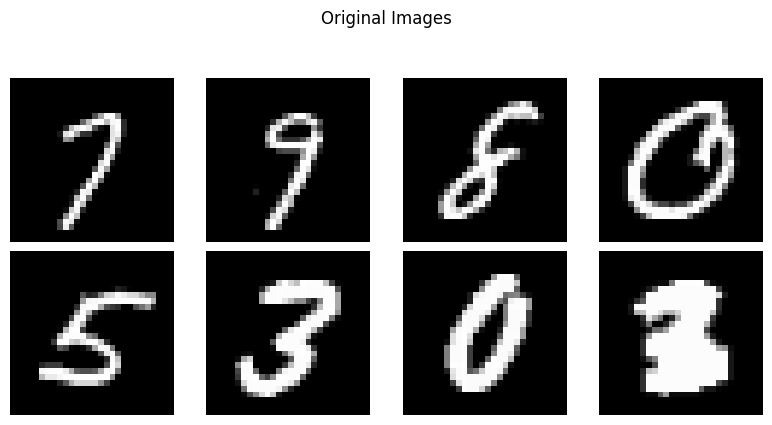

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [7]:
## Plotting utility
def plot_images(images, title):
    plt.figure(figsize=(8, 4)) # they're inches...
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle(title, y=1.05)
    plt.tight_layout()


## Visualize sample from dataset
with torch.no_grad():
    idx, (images, _) = next(enumerate(train_loader))

plot_images(images, title="Original Images")
plt.show()
print(images[0]) # grey scale in [0,1]

## Model and Training

In [8]:
## Build model
class AE(nn.Module):
    def __init__(self, input_dim, out_dim, latent_dim, hidden_dim=200):
        super().__init__()

        self.latent_dim = latent_dim
        
        ## Utilities
        self.flatten = nn.Flatten(1,3)
        self.activation = nn.ReLU()

        ## Encoder
        self.input2encoder_hid = nn.Linear(input_dim, hidden_dim)
        self.encoder_hid2latent = nn.Linear(hidden_dim, latent_dim)
        
        ## Decoder
        self.latent2decoder_hid = nn.Linear(latent_dim, hidden_dim)
        self.decoder_hid2sigm = nn.Linear(hidden_dim, out_dim)

        ## Out
        self.sigmoid = nn.Sigmoid()
        self.unflatten = nn.Unflatten(1, (1, 28, 28)) ## qua è rimasto 28...

    def encode(self, x):
        x = self.flatten(x)
        x = self.input2encoder_hid(x)
        x = self.activation(x)
        
        z = self.encoder_hid2latent(x)
        
        ## DEBUG
        # print(latent_param.size())
        # print(latent_param)
        
        return z

    def decode(self, z):
        ## Decode
        z = self.latent2decoder_hid(z)
        z = self.activation(z)
        z = self.decoder_hid2sigm(z)
        x_gen = self.sigmoid(z)
        x_gen = self.unflatten(x_gen)

        return x_gen

    def forward(self, x):
        z     = self.encode(x)
        x_gen = self.decode(z)

        return x_gen, z 

In [9]:
## Loss definition
loss = nn.MSELoss()
def lossL1(x, x_gen, z, lambd):
    criterion = nn.MSELoss()
    mse = criterion(x, x_gen)
    L1 = torch.sum(torch.abs(z))
    
    return mse + lambd*L1

def lossKL(x, x_gen, z, rho):
    criterion = nn.MSELoss()
    mse = criterion(x, x_gen)
    criterion_reg = nn.BCELoss() # corresponds to Dkl
    # Compute average (over minibatch) activation
    rho_hat = torch.mean(z, axis=0)
    Dkl = criterion_reg(rho*torch.ones_like(rho_hat), rho_hat)

    # volendo possiamo mettere 1 altro hyperparam a controllare il peso relativo...
    return mse + Dkl

In [10]:
a = torch.Tensor([1,2,-3])
b = torch.Tensor(1)
criterion = nn.MSELoss()
criterion(a,b*torch.ones_like(a))
# torch.sum(torch.abs(a))

tensor(4.6667)

In [11]:
a = torch.Tensor([[1,2,3],
                  [2,3,4]])
a.mean(axis=0)

tensor([1.5000, 2.5000, 3.5000])

In [12]:
model = AE(IMAGE_DIM, IMAGE_DIM, LATENT_DIM)
model = model.to(DEVICE)

## Optimizer choice
optimizer = optim.Adam(model.parameters(),
                      lr = LR,
                      weight_decay=WEIGHT_DECAY)

## Model summary
# print(model.parameters)

### Training

In [13]:
LAMBDA = .02
RHO = .02

# train loop
loss_train = []
loss_val   = []

for epoch in range(EPOCHS):
    loss_epoch = 0.0
    for x_train, _ in train_loader:
        x_train = x_train.to(DEVICE)
        
        x_gen, z = model(x_train) # in qlche modo qua sa che deve andare a prendere .forward()
        # computed_loss = lossL1(x_gen, x_train, z, LAMBDA)
        computed_loss = lossKL(x_gen, x_train, z, RHO)
        # computed_loss = loss(x_gen, x_train)
        loss_epoch += computed_loss.detach()
        
        optimizer.zero_grad()
        computed_loss.backward()
        optimizer.step()

    ## Loss record
    loss_epoch /= len(train_loader)
    loss_train.append(loss_epoch)

    with torch.no_grad():
        for x_val, _ in val_loader:
            x_val = x_val.to(DEVICE)
            
            x_gen_val, z = model(x_val)
            # val_computed_loss = lossL1(x_gen_val, x_val, z, LAMBDA)
            val_computed_loss = lossKL(x_gen_val, x_val, z, RHO)
            # val_computed_loss = loss(x_gen_val, x_val)
            loss_val.append(val_computed_loss.detach())
            
    print(f"Epoch: {epoch+1:2.0f} -- Loss = {loss_epoch:.5f} -- Val loss = {val_computed_loss:.5f}")

RuntimeError: all elements of target should be between 0 and 1

### Visualization

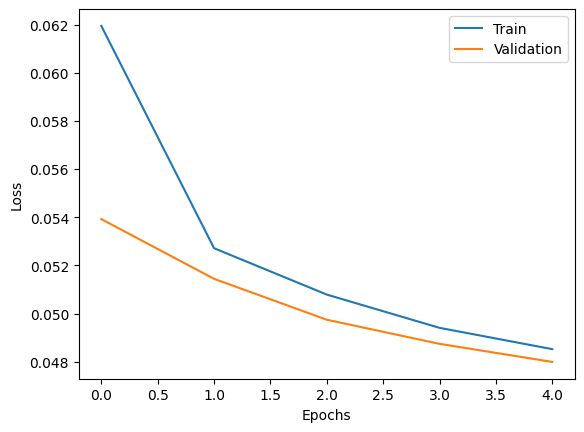

In [14]:
## Train and validation loss curves
plt.plot(loss_train, label = "Train")
plt.plot(loss_val  , label = "Validation")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.show()

In [15]:
image_iterator = enumerate(train_loader)

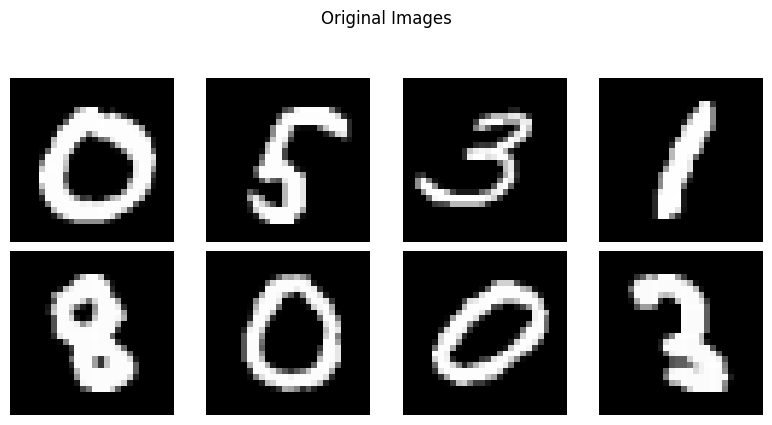

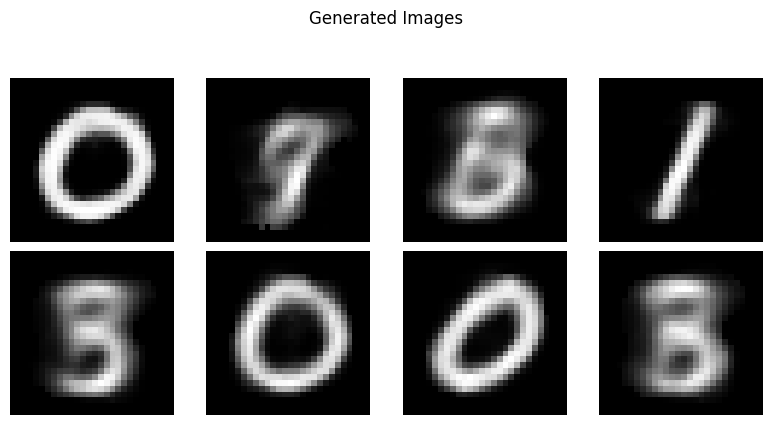

In [16]:
## Compare actual figures
with torch.no_grad():
    idx, (images, _) = next(image_iterator)
    images_gen, z = model(images)
    

plot_images(images, title="Original Images")
plot_images(images_gen, title="Generated Images")
plt.show()

In [17]:
## Sample from latent space
## Generate